## Accessing Data

In [0]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, RandomForestClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [12]:
Train = pd.read_csv('train.csv')
Test = pd.read_csv('test.csv')
#Preview the data
Test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Data Visualization

Correlation matrix (heatmap style) to get overview of data

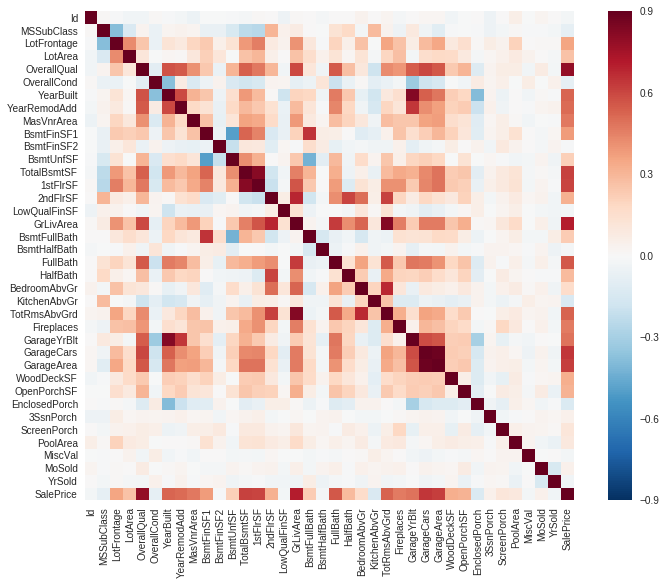

In [3]:
import seaborn as sns
corrmat = Train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

**SalePrice** correlation matrix (zoomed heatmap style)

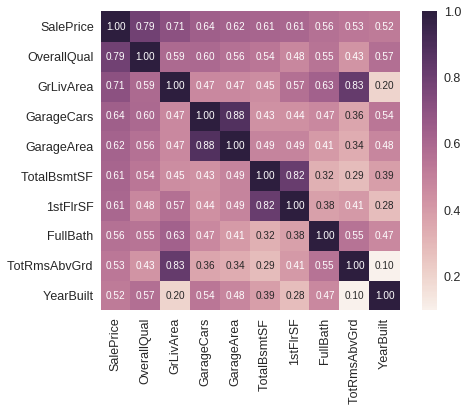

In [81]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(Train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

As we can see from the above **OverallQual**, **GrLivArea**


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f725f98f748>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


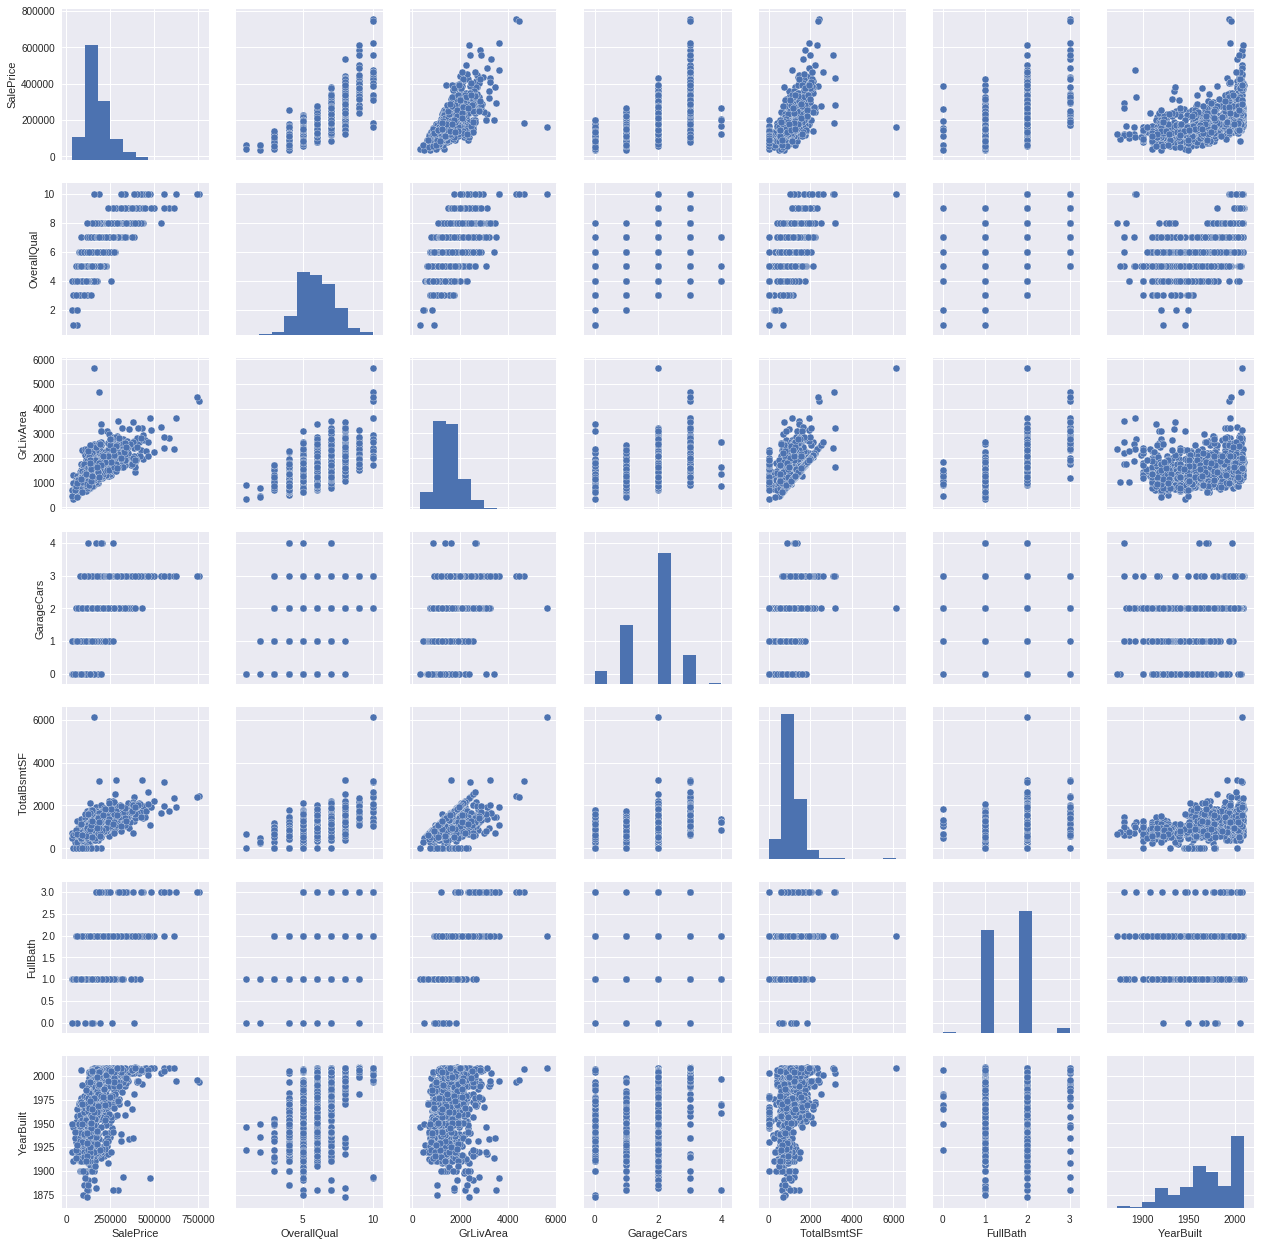

In [82]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(Train[cols], size = 2.5)
plt.show();

The plot shows data distribution and also some correlations between features.

## Data cleaning and Feature Engineering

The features and result are taken seperatly into X and y. The Id in the features is cutdown because it doesnt represent any valueble information in regards to House price. 

In [0]:
del Train['Id']
del Test['Id']


In [14]:
Train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [15]:
print(len(Test))
all_data_na = (Test.isnull().sum() / len(Test)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
print(all_data_na)

print(len(Train))
all_data_na = (Train.isnull().sum() / len(Train)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
print(all_data_na)

1459
PoolQC          99.794380
MiscFeature     96.504455
Alley           92.666210
Fence           80.123372
FireplaceQu     50.034270
LotFrontage     15.558602
GarageYrBlt      5.346127
GarageCond       5.346127
GarageQual       5.346127
GarageFinish     5.346127
GarageType       5.209047
BsmtCond         3.084304
BsmtExposure     3.015764
BsmtQual         3.015764
BsmtFinType1     2.878684
BsmtFinType2     2.878684
MasVnrType       1.096642
MasVnrArea       1.028101
MSZoning         0.274160
BsmtFullBath     0.137080
BsmtHalfBath     0.137080
Utilities        0.137080
Functional       0.137080
Exterior2nd      0.068540
Exterior1st      0.068540
SaleType         0.068540
BsmtFinSF1       0.068540
BsmtFinSF2       0.068540
BsmtUnfSF        0.068540
KitchenQual      0.068540
dtype: float64
1460
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType   

In [0]:
#it is advisable to remove the columns having high null values (considering the correlation of that variable)
Train.drop(columns={'PoolQC','MiscFeature','Alley','Fence','FireplaceQu'},inplace=True)
#there may be no garage, so filling NaN with 0
Train['GarageYrBlt']=Train['GarageYrBlt'].fillna(0)
#no masonry veneer for some houses
Train['MasVnrType']=Train['MasVnrType'].fillna('None')
Train['MasVnrArea']=Train['MasVnrArea'].fillna(0)
#NaN means there is no basement, so filling the null values with 'None'
for col in('BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'):
    Train[col]=Train.fillna('None')
#replacing null values with 'None' as there may be no garage in the house
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    Train[col] = Train[col].fillna('None')
    
#no basement, so filling it with zero
for col in ('BsmtFinSF1','TotalBsmtSF'):
    Train[col] = Train[col].fillna(0)
#filling with the most occurring value
Train['MSZoning'] = Train['MSZoning'].fillna(Train['MSZoning'].mode()[0])
#there is only one missing value, so filling it with mode
Train['Electrical']=Train['Electrical'].fillna(Train['Electrical'].mode()[0])

#mostly the dataset consists of same value in 'Utilities', so droping this feature
Train = Train.drop(['Utilities'], axis=1)

#NA for 'Functional' variable means typical (as per data description)
Train["Functional"] = Train["Functional"].fillna("Typ")
#filling it with most frequent value
Train['KitchenQual'] = Train['KitchenQual'].fillna(Train['KitchenQual'].mode()[0])
#as there is only one missing value, we will impute it with the most occurring value
Train['Exterior1st'] = Train['Exterior1st'].fillna(Train['Exterior1st'].mode()[0])
Train['Exterior2nd'] = Train['Exterior2nd'].fillna(Train['Exterior2nd'].mode()[0])
#imputing with mode
Train['SaleType'] = Train['SaleType'].fillna(Train['SaleType'].mode()[0])
#there is no garage, so fill it with 0
for col in ('GarageArea', 'GarageCars'):
    Train[col] = Train[col].fillna(0)
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
Train["LotFrontage"] = Train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [17]:
#checking if still the Train data set has null values or not 
null_columns=Train.columns[Train.isnull().any()]
Train[null_columns].isnull().sum()

Series([], dtype: float64)

In [0]:
Test.drop(columns={'PoolQC','MiscFeature','Alley','Fence','FireplaceQu'},inplace=True)
#there may be no garage, so filling NaN with 0
Test['GarageYrBlt']=Test['GarageYrBlt'].fillna(0)
#no masonry veneer for some houses
Test['MasVnrType']=Test['MasVnrType'].fillna('None')
Test['MasVnrArea']=Test['MasVnrArea'].fillna(0)
#NaN means there is no basement, so filling the null values with 'None'
for col in('BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'):
    Test[col]=Test.fillna('None')
#filling with the most occurring value
Test['MSZoning'] = Test['MSZoning'].fillna(Test['MSZoning'].mode()[0])
#there is only one missing value, so filling it with mode
Test['Electrical']=Test['Electrical'].fillna(Test['Electrical'].mode()[0])
#mostly the dataset consists of same value in 'Utilities', so droping this feature
Test = Test.drop(['Utilities'], axis=1)
#NA for 'Functional' variable means typical (as per data description)
Test["Functional"] = Test["Functional"].fillna("Typ")
#filling it with most frequent value
Test['KitchenQual'] = Test['KitchenQual'].fillna(Test['KitchenQual'].mode()[0])
#as there is only one missing value, we will impute it with the most occurring value
Test['Exterior1st'] = Test['Exterior1st'].fillna(Test['Exterior1st'].mode()[0])
Test['Exterior2nd'] = Test['Exterior2nd'].fillna(Test['Exterior2nd'].mode()[0])
#imputing with mode
Test['SaleType'] = Test['SaleType'].fillna(Test['SaleType'].mode()[0])
#there is no garage, so fill it with 0
for col in ('GarageArea', 'GarageCars'):
    Test[col] = Test[col].fillna(0)
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
Test["LotFrontage"] = Test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))


In [0]:
for col in('GarageType','GarageFinish','GarageQual','GarageCond'):
    Test[col]=Test.fillna('None')

In [0]:
#filling it with most frequent value
Test['BsmtFinSF1'] = Test['BsmtFinSF1'].fillna(Test['BsmtFinSF1'].mode()[0])
Test['BsmtFinSF2'] = Test['BsmtFinSF2'].fillna(Test['BsmtFinSF2'].mode()[0])
Test['BsmtUnfSF'] = Test['BsmtUnfSF'].fillna(Test['BsmtUnfSF'].mode()[0])
Test['TotalBsmtSF'] = Test['TotalBsmtSF'].fillna(Test['TotalBsmtSF'].mode()[0])
Test['BsmtFullBath'] = Test['BsmtFullBath'].fillna(Test['BsmtFullBath'].mode()[0])
Test['BsmtHalfBath'] = Test['BsmtHalfBath'].fillna(Test['BsmtHalfBath'].mode()[0])

In [21]:
#checking if still the data set has null values or not 
null_columns=Test.columns[Test.isnull().any()]
print(Test[null_columns].isnull().sum())

Series([], dtype: float64)


In [22]:
#performing label encoding for the categorical variables
from sklearn.preprocessing import LabelEncoder
cols = ( 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BldgType', 'BsmtExposure', 'Condition1', 'Condition2',
        'CentralAir', 'ExterQual', 'Electrical', 'ExterCond', 'Exterior1st', 'Exterior2nd', 'Functional', 'Foundation',
          'GarageQual', 'GarageType', 'GarageCond', 'GarageFinish', 'HeatingQC', 'HouseStyle', 'Heating',
        'HeatingQC',  'KitchenQual','LandSlope','LotConfig', 'LotShape', 'LandContour', 'MSZoning', 'MasVnrType', 'MasVnrArea',
        'Neighborhood', 'PavedDrive','RoofStyle', 'RoofMatl',  'Street', 'SaleType' , 'SaleCondition')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(Train[c].values)) 
    Train[c] = lbl.transform(list(Train[c].values))

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(Test[c].values)) 
    Test[c] = lbl.transform(list(Test[c].values))
    
print('Shape all_data: {}'.format(Train.shape))

Shape all_data: (1460, 74)


In [23]:
Train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,3,3,4,0,5,...,0,0,0,0,0,2,2008,8,4,208500
1,20,3,80.0,9600,1,3,3,2,0,24,...,0,0,0,0,0,5,2007,8,4,181500
2,60,3,68.0,11250,1,0,3,4,0,5,...,0,0,0,0,0,9,2008,8,4,223500
3,70,3,60.0,9550,1,0,3,0,0,6,...,272,0,0,0,0,2,2006,8,0,140000
4,60,3,84.0,14260,1,0,3,2,0,15,...,0,0,0,0,0,12,2008,8,4,250000


In [0]:
y =Train['SalePrice']
X = Train.drop(['SalePrice'], axis=1)

In [25]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
TestScaled = StandardScaler().fit_transform(Test)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [0]:
# train_test_split = np.random.rand(len(X)) < 0.70
# train_x = X[train_test_split]
# train_y = y[train_test_split]
# test_x = X[~train_test_split]
# test_y = y[~train_test_split]

## Training Different Models 

In [0]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [0]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [28]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of


Lasso score: 34321.9083 (7850.0311)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

ElasticNet score: 34321.1010 (7849.9852)

Xgboost score: 25827.6980 (4258.3824)

LGBM score: 27132.0182 (4473.1084)

Gradient Boosting score: 28000.6909 (5695.7987)



In [29]:
from sklearn.model_selection import cross_val_score

cross_val_score(GBoost, X, y, scoring='r2', cv=5)

array([0.91473004, 0.82835164, 0.88125403, 0.91488736, 0.82822856])